In [18]:
from typing import List, Dict
import numpy as np
import matplotlib.pyplot as plt

from PV_Generation import generate_PV_profile
from Load_Profiles import generate_load_profile
from Price_Forecast import generate_price_profile
from Agents import Prosumer
from Market import match_trades, match_local_market
from Regulator import Regulator
from BlockChain import Blockchain


In [19]:
def run_simulation(
    num_prosumers: int = 200,
    num_steps: int = 24,
    block_chain_difficulty: int = 3,
    # -------- Battery settings (community battery) --------
    battery_capacity_kwh: float = 500.0,
    battery_soc_init_kwh: float = 0.0,
    battery_charge_eff: float = 0.95,
    battery_discharge_eff: float = 0.95,
) -> Dict:

    # ---------------- Initialization ----------------
    prosumers: List[Prosumer] = []
    for i in range(num_prosumers):
        has_pv = (i < int(0.7 * num_prosumers))
        prosumers.append(Prosumer(id=i, has_pv=has_pv))

    pv, capacities = generate_PV_profile(num_prosumers, num_steps)
    loads = generate_load_profile(num_prosumers, num_steps)
    grid_price, fit_price = generate_price_profile(num_steps)

    regulator = Regulator(objective="maximize_p2p")

    blockchain = Blockchain(
        difficulty=block_chain_difficulty,
        miner_ids=list(range(10))
    )

    # Community battery state
    battery_soc = float(battery_soc_init_kwh)

    history = {
        # system metrics
        "total_load": [],
        "total_pv": [],
        "community_profit": [],
        "p2p_share": [],
        "objective_value": [],

        # energy flows
        "p2p_energy": [],
        "local_energy": [],
        "grid_import": [],
        "grid_export": [],

        # battery flows
        "battery_soc": [],
        "battery_charge": [],      # kWh absorbed from surplus (before eff)
        "battery_discharge": [],   # kWh supplied to deficits (after eff)
    }

    # ---------------- Time loop ----------------
    for t in range(num_steps):

        asks, bids = [], []

        imbalances = np.zeros(num_prosumers)
        sold = np.zeros(num_prosumers)
        bought = np.zeros(num_prosumers)

        p2p_energy = 0.0
        local_energy = 0.0

        # ---- Step 1: Self-balance & build P2P offers ----
        for i, p in enumerate(prosumers):

            pv_t = pv[i, t] if p.has_pv else 0.0
            load_t = loads[i, t]

            imbalance = p.self_balance(load_t, pv_t)  # pv-load
            imbalances[i] = imbalance

            role, qty, price = p.decide_P2P_offer(
                imbalance=imbalance,
                grid_price_t=grid_price[t]
            )

            if role == "seller":
                asks.append((p.id, qty, price))
            elif role == "buyer":
                bids.append((p.id, qty, price))

        # ---- Step 2: P2P market ----
        p2p_trades, rem_asks, rem_bids = match_trades(asks, bids)

        for tr in p2p_trades:
            s, b = tr["seller"], tr["buyer"]
            q, pr = tr["quantity"], tr["price"]

            prosumers[s].apply_trade_result("seller", q, pr)
            prosumers[b].apply_trade_result("buyer", q, pr)

            sold[s] += q
            bought[b] += q
            p2p_energy += q

        # ---- Step 3: Local market (aggregator) ----
        local_trades, _, _ = match_local_market(rem_asks, rem_bids, grid_price[t])

        for tr in local_trades:
            s, b = tr["seller"], tr["buyer"]
            q, pr = tr["quantity"], tr["price"]

            prosumers[s].apply_trade_result("seller", q, pr)
            prosumers[b].apply_trade_result("buyer", q, pr)

            sold[s] += q
            bought[b] += q
            local_energy += q

        # ---- Remaining imbalance after markets ----
        # (+) surplus, (-) deficit
        remaining_vec = imbalances - sold + bought

        # ---------------- Community Battery Layer ----------------
        # The battery acts AFTER markets, BEFORE grid settlement.
        # It absorbs surplus (charging) and supplies deficit (discharging) across time.

        battery_charge_kwh = 0.0     # kWh taken from surplus (before efficiency)
        battery_discharge_kwh = 0.0  # kWh delivered to loads (after efficiency)

        # 1) Charge from total surplus
        surplus_mask = remaining_vec > 1e-9
        total_surplus = float(np.sum(remaining_vec[surplus_mask]))

        if total_surplus > 0 and battery_soc < battery_capacity_kwh:
            # How much can we absorb from surplus given remaining capacity and charge efficiency?
            max_absorb_from_surplus = (battery_capacity_kwh - battery_soc) / battery_charge_eff
            battery_charge_kwh = min(total_surplus, max_absorb_from_surplus)

            # Increase SOC by stored energy (= absorbed * eff)
            battery_soc += battery_charge_kwh * battery_charge_eff

            # Reduce each surplus prosumer proportionally (battery "buys" surplus)
            frac = battery_charge_kwh / total_surplus
            remaining_vec[surplus_mask] = remaining_vec[surplus_mask] * (1.0 - frac)

        # 2) Discharge to cover total deficit (using SOC from previous steps)
        deficit_mask = remaining_vec < -1e-9
        total_deficit = float(np.sum(-remaining_vec[deficit_mask]))

        if total_deficit > 0 and battery_soc > 1e-9:
            # Max energy we can deliver to loads this step (SOC * discharge_eff)
            max_deliver = battery_soc * battery_discharge_eff
            battery_discharge_kwh = min(total_deficit, max_deliver)

            # Reduce SOC by the amount taken out (delivered/eff)
            battery_soc -= battery_discharge_kwh / battery_discharge_eff

            # Reduce each deficit proportionally (battery "supplies" energy)
            frac = battery_discharge_kwh / total_deficit
            remaining_vec[deficit_mask] = remaining_vec[deficit_mask] * (1.0 - frac)

        # ---------------- Step 4: Grid settlement ----------------
        grid_import, grid_export = 0.0, 0.0

        for i, p in enumerate(prosumers):
            remaining = float(remaining_vec[i])

            gi, ge = p.settle_with_grid(
                remaining_imbalance=remaining,
                grid_price_t=grid_price[t],
                fit_price=fit_price
            )
            grid_import += gi
            grid_export += ge

        # ---------------- Metrics ----------------
        total_load = float(loads[:, t].sum())
        total_pv = float(pv[:, t].sum())
        community_profit = float(sum(p.money for p in prosumers))

        traded_total = p2p_energy + local_energy
        p2p_share = p2p_energy / (traded_total + 1e-6)

        history["total_load"].append(total_load)
        history["total_pv"].append(total_pv)
        history["p2p_energy"].append(p2p_energy)
        history["local_energy"].append(local_energy)
        history["grid_import"].append(grid_import)
        history["grid_export"].append(grid_export)
        history["community_profit"].append(community_profit)
        history["p2p_share"].append(p2p_share)

        # battery metrics
        history["battery_soc"].append(battery_soc)
        history["battery_charge"].append(battery_charge_kwh)
        history["battery_discharge"].append(battery_discharge_kwh)

        # ---- Regulator ----
        obj_value = regulator.evaluate_objective({
            "p2p_share": p2p_share,
            "community_profit": community_profit
        })
        history["objective_value"].append(obj_value)
        regulator.apply_rules(prosumers)

        # ---- Blockchain ----
        blockchain.mine_block(p2p_trades + local_trades)

    return {
        "history": history,
        "blockchain": blockchain,
        "raw_data": {
            "pv": pv,
            "loads": loads,
            "grid_price": grid_price,
            "fit_price": fit_price,
            "capacities": capacities
        }
    }

In [20]:
results = run_simulation(num_prosumers=200, num_steps=24)
history = results["history"]


Numerical Summary 

In [25]:
history = results["history"]

print("===== SYSTEM SUMMARY =====")
print(f"Total load (kWh): {sum(history['total_load']):.1f}")
print(f"Total PV generation (kWh): {sum(history['total_pv']):.1f}")

print(f"Total P2P energy (kWh): {sum(history['p2p_energy']):.1f}")
print(f"Total Battery charge (kWh): {sum(history['battery_charge']):.1f}")
print(f"Total Battery discharge (kWh): {sum(history['battery_discharge']):.1f}")

print(f"Total Grid import (kWh): {sum(history['grid_import']):.1f}")
print(f"Total Grid export (kWh): {sum(history['grid_export']):.1f}")

print(f"Final community profit (€): {history['community_profit'][-1]:.2f}")
print(f"Average P2P share: {np.mean(history['p2p_share']):.2f}")


===== SYSTEM SUMMARY =====
Total load (kWh): 3911.4
Total PV generation (kWh): 4999.7
Total P2P energy (kWh): 92.1
Total Battery charge (kWh): 618.0
Total Battery discharge (kWh): 557.7
Total Grid import (kWh): 2696.0
Total Grid export (kWh): 2412.0
Final community profit (€): -503.65
Average P2P share: 0.25


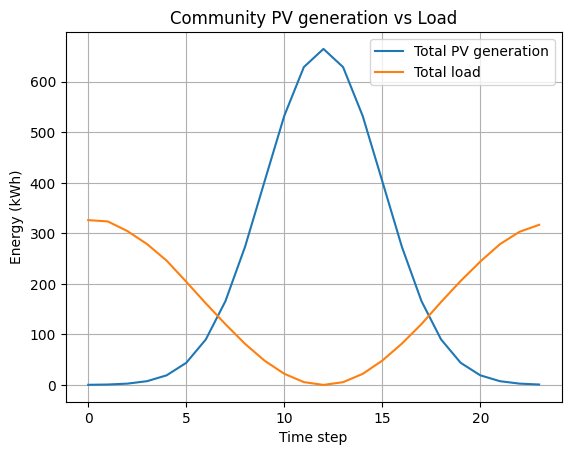

In [26]:
plt.figure()
plt.plot(history["total_pv"], label="Total PV generation")
plt.plot(history["total_load"], label="Total load")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Community PV generation vs Load")
plt.legend()
plt.grid(True)
plt.show()


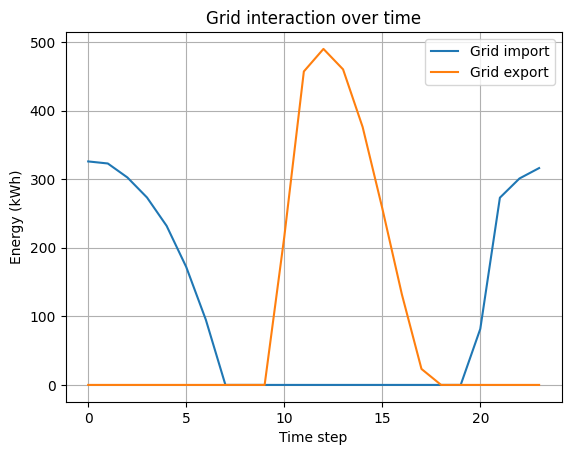

In [27]:
plt.figure()
plt.plot(history["grid_import"], label="Grid import")
plt.plot(history["grid_export"], label="Grid export")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Grid interaction over time")
plt.legend()
plt.grid(True)
plt.show()


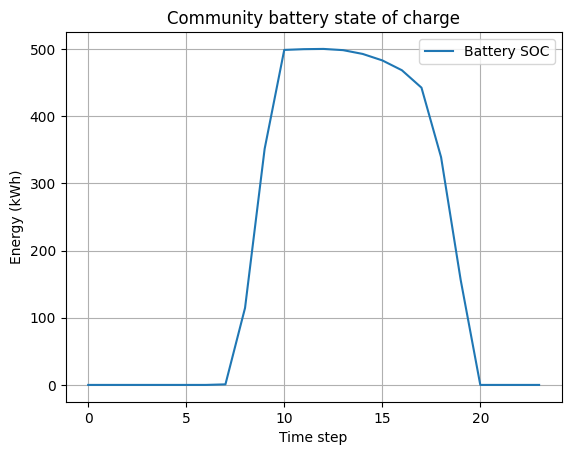

In [28]:
plt.figure()
plt.plot(history["battery_soc"], label="Battery SOC")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Community battery state of charge")
plt.legend()
plt.grid(True)
plt.show()


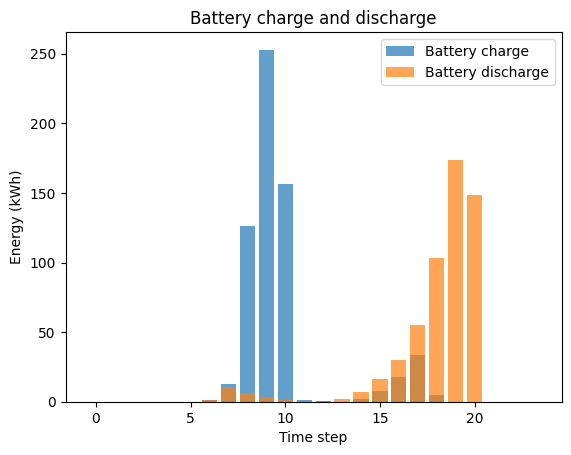

In [29]:
plt.figure()
plt.bar(range(len(history["battery_charge"])),
        history["battery_charge"], label="Battery charge", alpha=0.7)
plt.bar(range(len(history["battery_discharge"])),
        history["battery_discharge"], label="Battery discharge", alpha=0.7)
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Battery charge and discharge")
plt.legend()
plt.show()


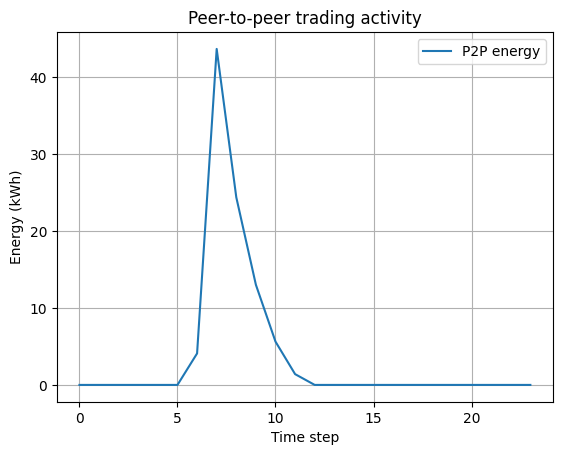

In [30]:
plt.figure()
plt.plot(history["p2p_energy"], label="P2P energy")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Peer-to-peer trading activity")
plt.legend()
plt.grid(True)
plt.show()


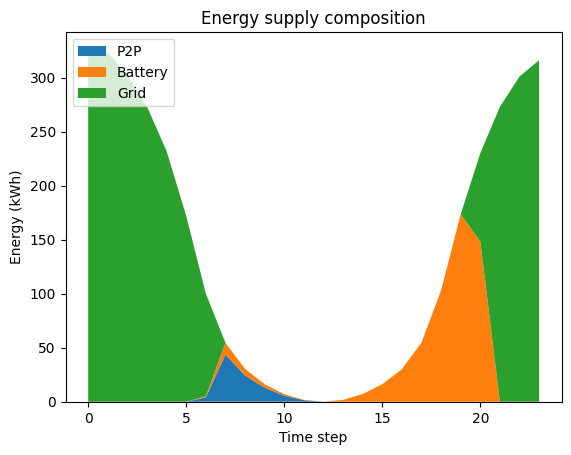

In [31]:
plt.figure()
plt.stackplot(
    range(len(history["total_load"])),
    history["p2p_energy"],
    history["battery_discharge"],
    history["grid_import"],
    labels=["P2P", "Battery", "Grid"]
)
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Energy supply composition")
plt.legend(loc="upper left")
plt.show()


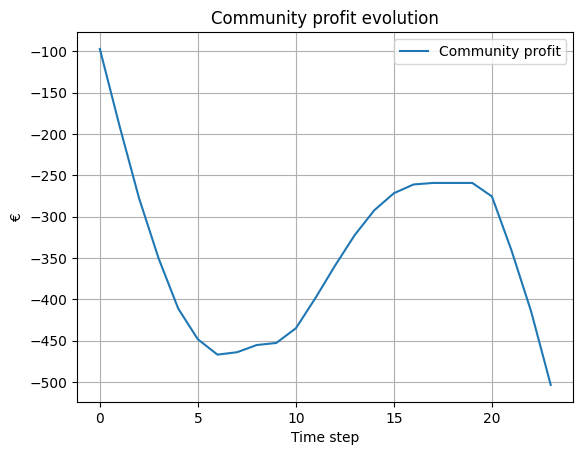

In [32]:
plt.figure()
plt.plot(history["community_profit"], label="Community profit")
plt.xlabel("Time step")
plt.ylabel("€")
plt.title("Community profit evolution")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
import numpy as np

h = results["history"]

total_p2p = float(np.sum(h["p2p_energy"]))
total_local_in = float(np.sum(h["battery_charge"]))      # local absorption
total_local_out = float(np.sum(h["battery_discharge"]))  # local supply
total_grid_in = float(np.sum(h["grid_import"]))
total_grid_out = float(np.sum(h["grid_export"]))

print("===== TRADING SUMMARY =====")
print(f"P2P traded energy (kWh): {total_p2p:.1f}")

print(f"Local (battery) absorbed (kWh): {total_local_in:.1f}")
print(f"Local (battery) supplied  (kWh): {total_local_out:.1f}")

print(f"Grid import (kWh): {total_grid_in:.1f}")
print(f"Grid export (kWh): {total_grid_out:.1f}")

# Shares (good for slides)
total_supply_to_load = float(np.sum(h["total_load"]))  # approximate denominator
print("\n===== SUPPLY SHARES (rough, for slides) =====")
print(f"P2P / Load: {total_p2p/total_supply_to_load:.2%}")
print(f"Battery discharge / Load: {total_local_out/total_supply_to_load:.2%}")
print(f"Grid import / Load: {total_grid_in/total_supply_to_load:.2%}")


===== TRADING SUMMARY =====
P2P traded energy (kWh): 92.1
Local (battery) absorbed (kWh): 618.0
Local (battery) supplied  (kWh): 557.7
Grid import (kWh): 2696.0
Grid export (kWh): 2412.0

===== SUPPLY SHARES (rough, for slides) =====
P2P / Load: 2.35%
Battery discharge / Load: 14.26%
Grid import / Load: 68.93%


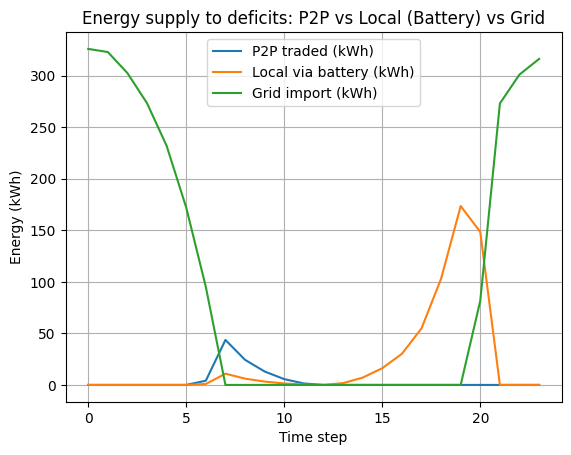

In [34]:
import matplotlib.pyplot as plt

t = range(len(h["p2p_energy"]))

plt.figure()
plt.plot(t, h["p2p_energy"], label="P2P traded (kWh)")
plt.plot(t, h["battery_discharge"], label="Local via battery (kWh)")
plt.plot(t, h["grid_import"], label="Grid import (kWh)")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Energy supply to deficits: P2P vs Local (Battery) vs Grid")
plt.legend()
plt.grid(True)
plt.show()


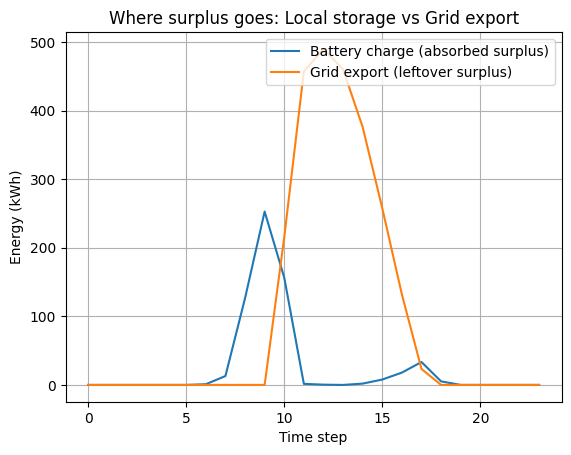

In [35]:
plt.figure()
plt.plot(t, h["battery_charge"], label="Battery charge (absorbed surplus)")
plt.plot(t, h["grid_export"], label="Grid export (leftover surplus)")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Where surplus goes: Local storage vs Grid export")
plt.legend()
plt.grid(True)
plt.show()


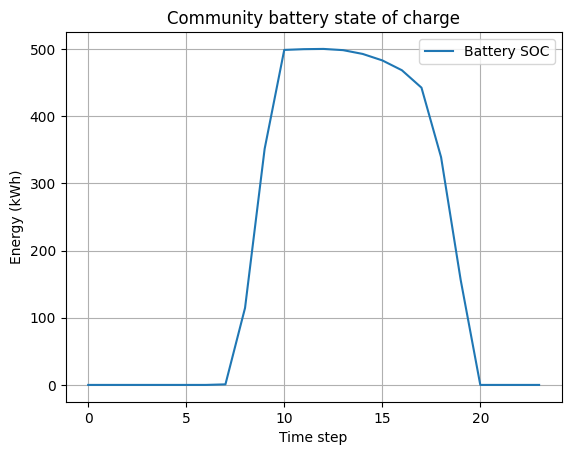

In [36]:
plt.figure()
plt.plot(t, h["battery_soc"], label="Battery SOC")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Community battery state of charge")
plt.legend()
plt.grid(True)
plt.show()


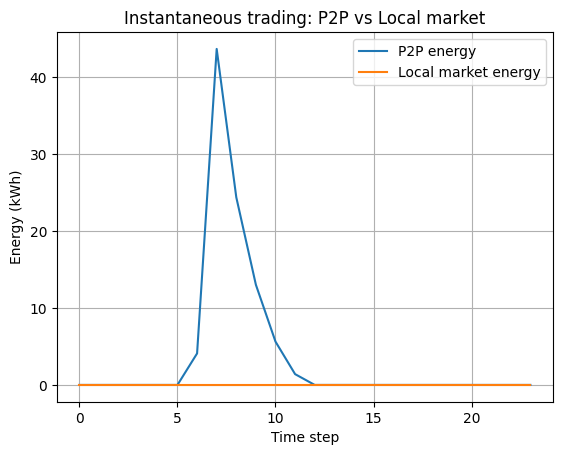

In [37]:
plt.figure()
plt.plot(t, h["p2p_energy"], label="P2P energy")
plt.plot(t, h.get("local_energy", [0]*len(h["p2p_energy"])), label="Local market energy")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Instantaneous trading: P2P vs Local market")
plt.legend()
plt.grid(True)
plt.show()


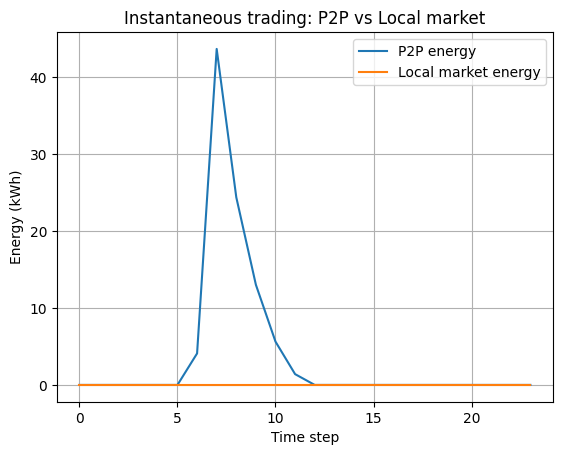

In [38]:
plt.figure()
plt.plot(t, h["p2p_energy"], label="P2P energy")
plt.plot(t, h.get("local_energy", [0]*len(h["p2p_energy"])), label="Local market energy")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Instantaneous trading: P2P vs Local market")
plt.legend()
plt.grid(True)
plt.show()


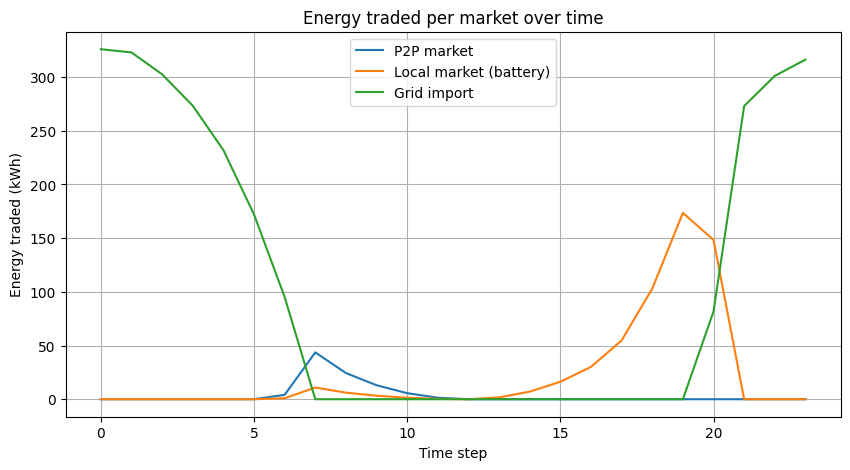

In [39]:
import matplotlib.pyplot as plt

t = range(len(h["p2p_energy"]))

plt.figure(figsize=(10,5))
plt.plot(t, h["p2p_energy"], label="P2P market")
plt.plot(t, h["battery_discharge"], label="Local market (battery)")
plt.plot(t, h["grid_import"], label="Grid import")

plt.xlabel("Time step")
plt.ylabel("Energy traded (kWh)")
plt.title("Energy traded per market over time")
plt.legend()
plt.grid(True)
plt.show()


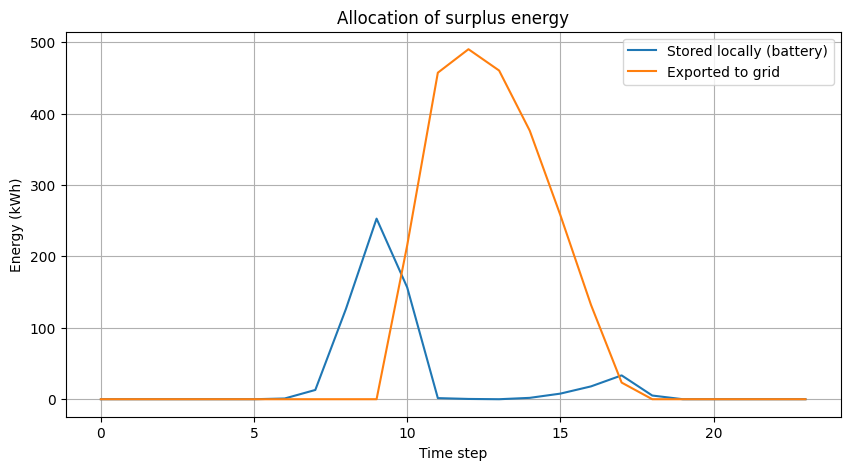

In [40]:
plt.figure(figsize=(10,5))
plt.plot(t, h["battery_charge"], label="Stored locally (battery)")
plt.plot(t, h["grid_export"], label="Exported to grid")

plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.title("Allocation of surplus energy")
plt.legend()
plt.grid(True)
plt.show()


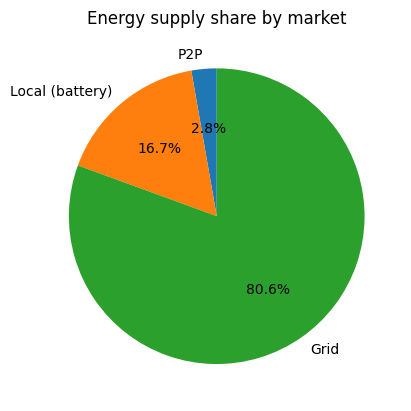

In [41]:
total_p2p = np.sum(h["p2p_energy"])
total_local = np.sum(h["battery_discharge"])
total_grid = np.sum(h["grid_import"])

plt.figure()
plt.pie(
    [total_p2p, total_local, total_grid],
    labels=["P2P", "Local (battery)", "Grid"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Energy supply share by market")
plt.show()


In [42]:
import numpy as np
import matplotlib.pyplot as plt

h = results["history"]
grid_price = results["raw_data"]["grid_price"]

hours = np.arange(len(h["total_load"]))

grid_consumption = np.array(h["grid_import"])
p2p_consumption = np.array(h["p2p_energy"])
total_consumption = np.array(h["total_load"])

# Approximate P2P price advantage (10% cheaper than grid)
p2p_price = 0.9 * grid_price

financial_benefit = p2p_consumption * (grid_price - p2p_price)


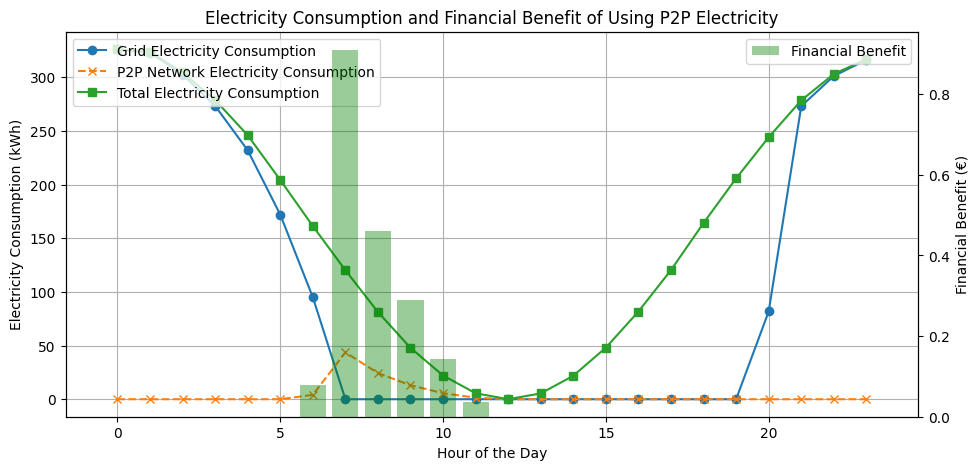

In [43]:
fig, ax1 = plt.subplots(figsize=(11,5))

# Left axis: energy
ax1.plot(hours, grid_consumption, 'o-', label="Grid Electricity Consumption")
ax1.plot(hours, p2p_consumption, 'x--', label="P2P Network Electricity Consumption")
ax1.plot(hours, total_consumption, 's-', label="Total Electricity Consumption")

ax1.set_xlabel("Hour of the Day")
ax1.set_ylabel("Electricity Consumption (kWh)")
ax1.legend(loc="upper left")
ax1.grid(True)

# Right axis: financial benefit
ax2 = ax1.twinx()
ax2.bar(hours, financial_benefit, alpha=0.4, color="green", label="Financial Benefit")
ax2.set_ylabel("Financial Benefit (€)")
ax2.legend(loc="upper right")

plt.title("Electricity Consumption and Financial Benefit of Using P2P Electricity")
plt.show()
